JAYA SURYA

In [1]:
# Importing Libraries
import pandas_datareader.data as web
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf,acf,pacf
from pandas.plotting import lag_plot
from pmdarima.arima import auto_arima
from pmdarima.arima import ADFTest
import statsmodels.api as sm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
import math
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression



DATA COLLECTION

In [2]:
# Reading CSV file which contains stock names from different industries from S & P 500 
# This file has been sourced from https://finance.yahoo.com/

stocks=pd.read_csv("D:\Dissertation\StockMarketPrediction\constituents_csv.csv")

In [3]:
# Finding the top 5 values
stocks.head()

,Symbol,Name,Sector
0,MMM,3M,Industrials
1,AOS,A. O. Smith,Industrials
2,ABT,Abbott Laboratories,Health Care
3,ABBV,AbbVie,Health Care
4,ABMD,Abiomed,Health Care


In [3]:
# Checking the industries in different sectors
stocks['Sector'].value_counts()

Industrials               74
Information Technology    74
Financials                65
Health Care               64
Consumer Discretionary    63
Consumer Staples          32
Real Estate               29
Utilities                 28
Materials                 28
Communication Services    27
Energy                    21
Name: Sector, dtype: int64

In [4]:
# There are two industries which are occupied with more companies
# We are concentrating more on Information Technology

companies_it=stocks[stocks['Sector'].isin(["Information Technology"])]

In [5]:
# Extracted company names in IT sector.
companies_it.head()

,Symbol,Name,Sector
5,ACN,Accenture,Information Technology
8,ADBE,Adobe,Information Technology
10,AMD,Advanced Micro Devices,Information Technology
15,AKAM,Akamai Technologies,Information Technology
39,APH,Amphenol,Information Technology


In [6]:
# Checking the unique companies 
uniq_stocks=list(companies_it['Symbol'].unique())

# Checking the symbols of 5 companies
uniq_stocks[:5]

['ACN', 'ADBE', 'AMD', 'AKAM', 'APH']

In [7]:
# Extracting the data from public website yahoo.finance
# using DataReader libraries from pandas. This will be the main file.
main_df=pd.DataFrame()
invalid_stoc=[]
for sto in uniq_stocks:
    try:
        sto_time=web.DataReader(sto,'yahoo')
        sto_time['Stock_Name']=sto
        main_df=pd.concat([main_df,sto_time])
    except Exception as e :
        #print(e)
        invalid_stoc.append(e)


# Checking the sample data from the main data frame
main_df.sample(5)

,High,Low,Open,Close,Volume,Adj Close,Stock_Name
Date,,,,,,,
2022-09-07,92.769997,89.879997,90.570000,91.940002,5567500.0,91.716682,AMAT
2019-11-27,319.940002,316.470001,317.940002,318.440002,2018200.0,286.025970,AVGO
2017-12-13,72.120003,71.059998,71.800003,71.190002,3129000.0,66.738098,CTSH
2018-09-27,99.139999,97.980003,98.029999,98.650002,1109200.0,98.650002,SNPS
2019-01-04,61.950001,59.020000,59.360001,61.950001,1737000.0,61.950001,KEYS


In [ ]:
# Saving the file
main_dataset=main_df.to_csv('D:\Dissertation\StockMarketPrediction\main_Dataset.csv')

DATA PROCESSING

In [8]:
# Extract the data for  IT company  Accenture and Adobe
main_ACN=main_df[main_df['Stock_Name']=='ACN']
main_ADB=main_df[main_df['Stock_Name']=='ADBE']

In [10]:
main_ACN.head()

,High,Low,Open,Close,Volume,Adj Close,Stock_Name
Date,,,,,,,
2017-12-01,148.360001,145.750000,147.699997,146.570007,1971600.0,136.363327,ACN
2017-12-04,147.970001,146.080002,147.500000,147.149994,2099800.0,136.902878,ACN
2017-12-05,148.479996,146.789993,147.240005,147.669998,1398900.0,137.386673,ACN
2017-12-06,148.479996,147.270004,147.979996,148.270004,1363400.0,137.944916,ACN
2017-12-07,148.660004,147.240005,148.000000,148.600006,1526400.0,138.251938,ACN


In [11]:
main_ACN.tail()

,High,Low,Open,Close,Volume,Adj Close,Stock_Name
Date,,,,,,,
2022-11-23,296.390015,292.399994,293.079987,294.529999,1229100.0,294.529999,ACN
2022-11-25,297.519989,294.299988,294.299988,296.399994,677900.0,296.399994,ACN
2022-11-28,294.970001,289.779999,293.260010,290.600006,1253100.0,290.600006,ACN
2022-11-29,290.619995,286.619995,289.309998,287.980011,1055000.0,287.980011,ACN
2022-11-30,300.790009,286.230011,286.619995,300.059998,1092096.0,300.059998,ACN


In [9]:
main_ACN.describe()

,High,Low,Open,Close,Volume,Adj Close
count,1258.000000,1258.000000,1258.000000,1258.000000,1.258000e+03,1258.000000
mean,232.926152,228.492258,230.659928,230.740580,2.149042e+06,224.110796
std,68.452594,67.023832,67.747930,67.690030,8.978888e+05,69.780498
min,136.919998,132.630005,134.800003,133.669998,5.281000e+05,126.605682
25%,169.289993,165.947502,167.439995,167.220001,1.598000e+06,158.041290
50%,212.435005,209.595001,210.910004,211.595001,1.952250e+06,203.458511
75%,287.902496,283.037506,285.559990,285.690010,2.412450e+06,281.288750
max,417.369995,413.679993,416.260010,415.420013,8.561500e+06,409.828979


In [ ]:
# Checking the null values 
main_ACN.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2017-11-21 to 2022-11-18
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   High        1258 non-null   float64
 1   Low         1258 non-null   float64
 2   Open        1258 non-null   float64
 3   Close       1258 non-null   float64
 4   Volume      1258 non-null   float64
 5   Adj Close   1258 non-null   float64
 6   Stock_Name  1258 non-null   object 
dtypes: float64(6), object(1)
memory usage: 78.6+ KB


Text(0.5, 1.0, 'Accenture Closing Price')

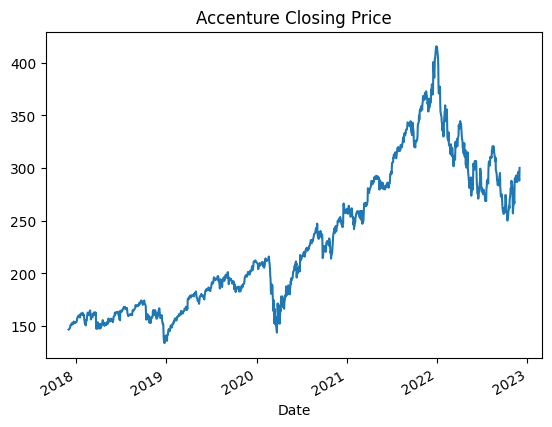

In [15]:
main_ACN['Close'].plot()
plt.title('Accenture Closing Price')

In [ ]:
# Checking the correlation values
corr = main_ACN.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(3)

C:\Users\PraVeeN\AppData\Local\Temp\ipykernel_1680\2102040169.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = main_ACN.corr()
C:\Users\PraVeeN\AppData\Local\Temp\ipykernel_1680\2102040169.py:3: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap='coolwarm').set_precision(3)


,High,Low,Open,Close,Volume,Adj Close
High,1.000,0.999,0.999,0.999,-0.030,0.999
Low,0.999,1.000,0.999,0.999,-0.054,0.999
Open,0.999,0.999,1.000,0.999,-0.041,0.999
Close,0.999,0.999,0.999,1.000,-0.044,1.000
Volume,-0.030,-0.054,-0.041,-0.044,1.000,-0.040
Adj Close,0.999,0.999,0.999,1.000,-0.040,1.000


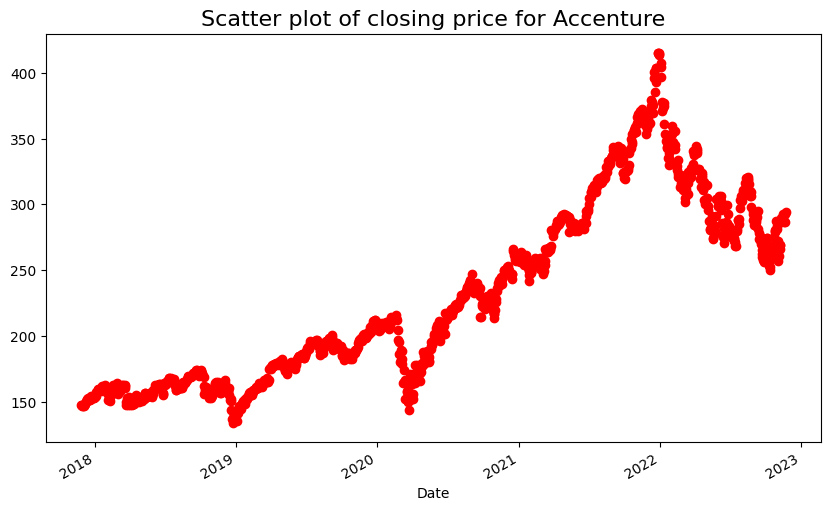

In [ ]:
# Scatter plot for the closing price for one company - Accenture
plt.figure(figsize=(10,6))
df_close = main_ACN['Close']
df_close.plot(style='or')
plt.title('Scatter plot of closing price for Accenture')
plt.show()

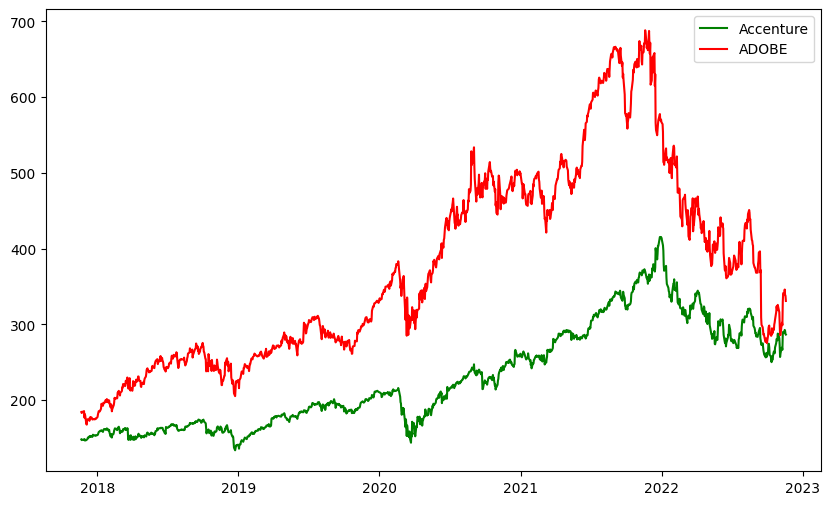

In [ ]:
# Line plot for two companies Accenture and Adobe
plt.figure(figsize=(10,6))
plt.plot(main_ACN['Close'], 'g', label='Accenture')
plt.plot(main_ADB['Close'], 'r', label='ADOBE')
plt.legend()
plt.show()

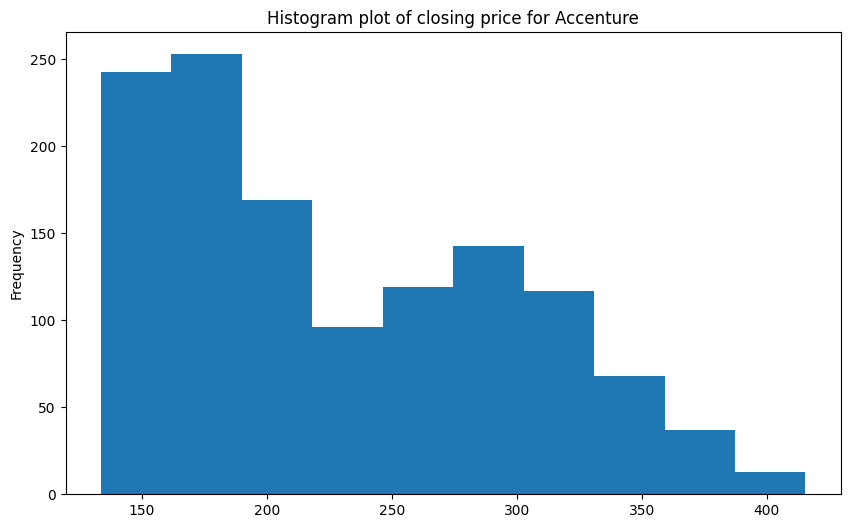

In [ ]:
# Histogram plot to understand the variation  for Accenture

plt.figure(figsize=(10,6))
df_close = main_ACN['Close']
df_close.plot(style='k.',kind='hist')
plt.title('Histogram plot of closing price for Accenture')
plt.show()

In [ ]:
# Checking the seasonality and identifying the trend for Accenture stock 
sd_acn=seasonal_decompose(main_ACN['Close'],period=365)

<AxesSubplot: xlabel='Date'>

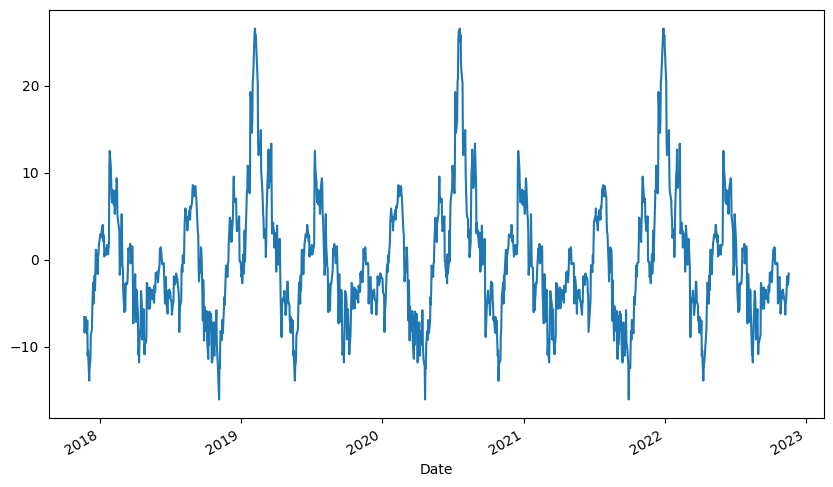

In [ ]:
# From the below figure we can understand their is some seasonality for the ADOBE stock
plt.figure(figsize=(10,6))
sd_acn.seasonal.plot()

<AxesSubplot: xlabel='Date'>

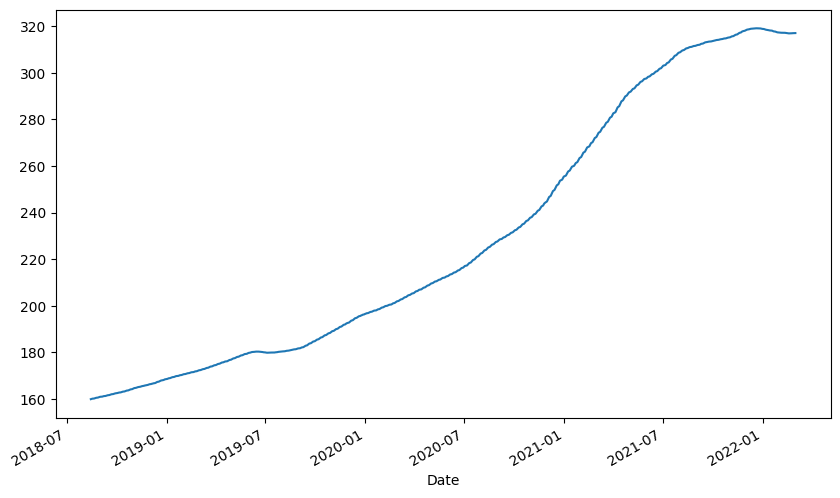

In [ ]:
# There is an increasing trend for this stock
plt.figure(figsize=(10,6))
sd_acn.trend.plot()

<Figure size 2000x1000 with 0 Axes>

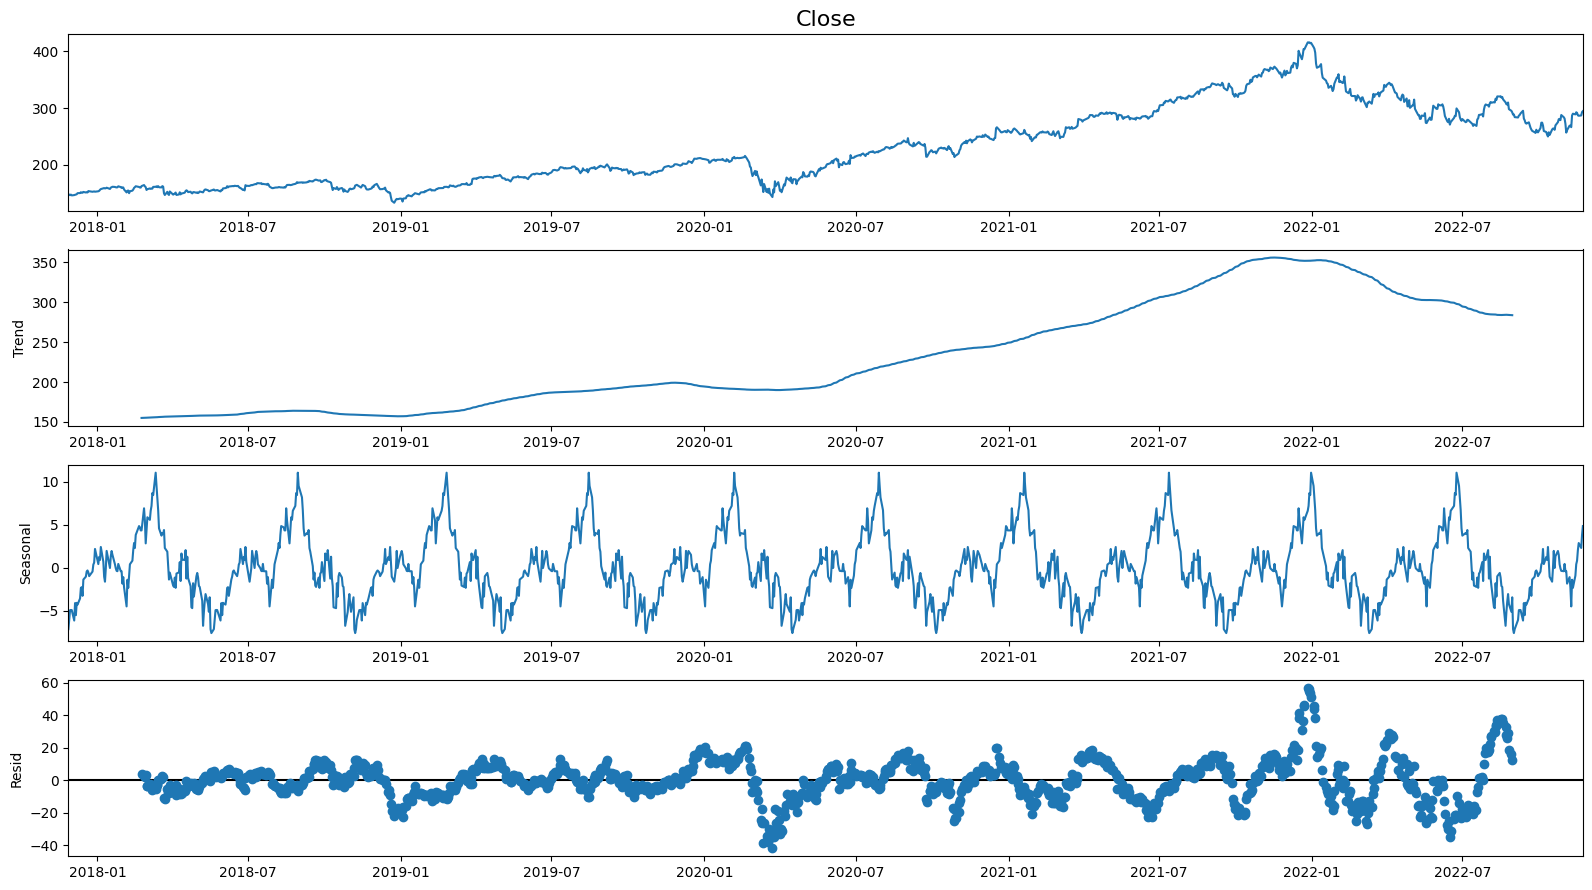

In [ ]:
# Understanding the trend , Seasonality and Residuals for the Data set

decompose_7=seasonal_decompose(main_ACN['Close'],period=120)

plt.figure(figsize=(20,10))
fig=decompose_7.plot()
fig.set_size_inches((16, 9))
# Tight layout to realign things
fig.tight_layout()
plt.show()

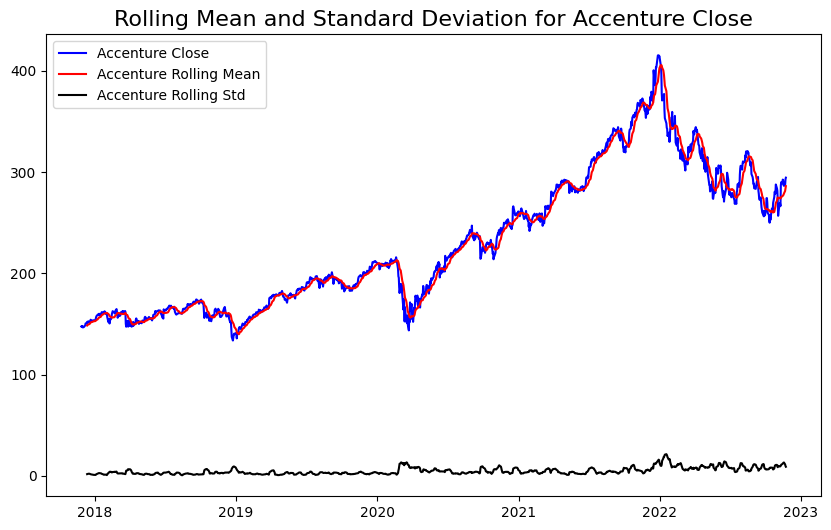

In [ ]:
# There are two ways we can find whether the data is stationary or not 
# 1) Dickey Fuller Test 
# 2) Rolling mean and Standard deviation test
# Checking whether the Adobe stock data is stationery or not using Dickey Fuller test and Rolling Mean and Rolling Standard Deviation

ACN_close=main_ACN['Close']
rolmean_acn = ACN_close.rolling(12).mean()
rolstd_acn = ACN_close.rolling(12).std()

# Graph for Rolling Mean and St Deviation  :
plt.figure(figsize=(10,6))
plt.plot(ACN_close, color='blue',label='Accenture Close')
plt.plot(rolmean_acn, color='red', label='Accenture Rolling Mean')
plt.plot(rolstd_acn, color='black', label = 'Accenture Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean and Standard Deviation for Accenture Close')
plt.show(block=False)

# Standard Deviation is constant but mean is not constant , so it is not stationary

In [ ]:
#Dickey Fuller test to check for stationarity
print("Results of dickey fuller test for Adobe Stock Closing Price ")
adft = adfuller(ACN_close,autolag='AIC')
adft
output_df = pd.DataFrame({"Values":[adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']]  , "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used", 
                                                        "critical value (1%)", "critical value (5%)", "critical value (10%)"]})

print(output_df)

Results of dickey fuller test for Adobe Stock Closing Price 
        Values                       Metric
0    -1.291349              Test Statistics
1     0.633121                      p-value
2     9.000000             No. of lags used
3  1248.000000  Number of observations used
4    -3.435601          critical value (1%)
5    -2.863859          critical value (5%)
6    -2.568004         critical value (10%)


In [ ]:
# Checking whether data is Auto Correlated or not
# Autocorrelation in Python is another important part of the analytic process. This is a measure of how correlated time series data is at a given point in time with past values.

# Auto correlation for Adobe stock price across 3, 4, 6 months

acn_lag7=ACN_close.autocorr(lag=7)
acn_lag21=ACN_close.autocorr(lag=21)
print(acn_lag7)
print(acn_lag21)


0.9881976209916858
0.962016361794201


<AxesSubplot: xlabel='y(t)', ylabel='y(t + 1)'>

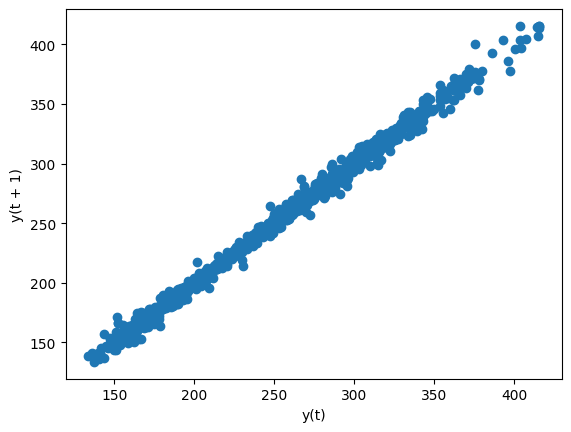

In [ ]:
lag_plot(ACN_close)
# It clearly shows correlation

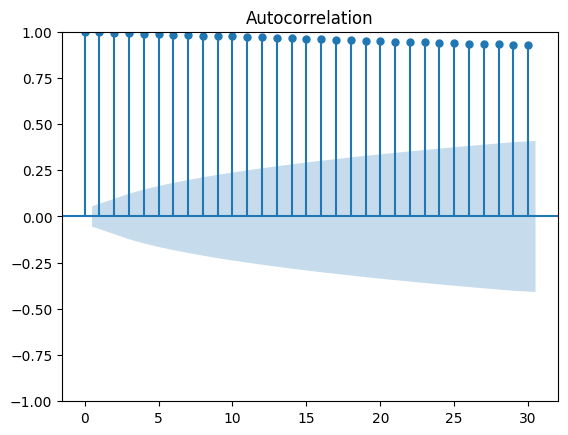

In [ ]:
plot_acf(ACN_close, lags = 30)
print()

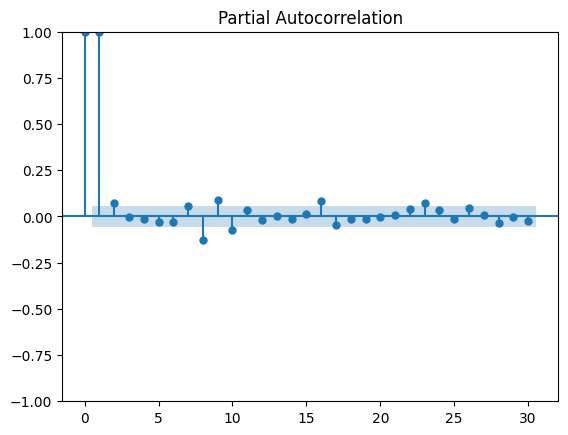

In [ ]:
plot_pacf(ACN_close, lags = 30, method = "ols")
print()

In [ ]:
# Rolling Moving Average Model

ma_acn=main_ACN['Close'].rolling(20).mean()

In [ ]:
# Exponential Moving Average model with threshold 0.4
ewm_acn=main_ACN['Close'].ewm(com=0.4).mean()

In [ ]:
main_ACN.head()

,High,Low,Open,Close,Volume,Adj Close,Stock_Name
Date,,,,,,,
2017-11-21,148.470001,146.410004,147.000000,148.009995,1732000.0,137.703018,ACN
2017-11-22,148.320007,147.029999,147.850006,147.110001,1263700.0,136.865723,ACN
2017-11-24,148.169998,146.800003,148.169998,147.630005,601800.0,137.349518,ACN
2017-11-27,148.100006,147.429993,148.000000,147.500000,1352100.0,137.228516,ACN
2017-11-28,148.490005,146.649994,148.009995,148.039993,1925900.0,137.730927,ACN


In [ ]:
main_ACN=main_ACN.sort_index()

In [ ]:
# Splitting Train & Test 
#  In time series , we have to split the data set based on time period , we can't sample and split the data
train=main_ACN[:1228]
test=main_ACN[1228:]


In [ ]:
x_train=train[['Close']]
x_test=test[['Close']]

ARIMA MODELS

In [ ]:
#Auto ARIMA model, note that small p,d,q values represent non-seasonal components, 
#and capital P, D, Q represent seasonal components.

arima_auto_train=auto_arima(x_train,start_p=0,d=0,start_q=0,max_d=3,max_p=3,max_q=3,
                      start_P=0,start_Q=0,D=0,max_P=3,max_Q=3,max_D=3,m=12,seasonal=True,trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=13856.879, Time=0.05 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=1.01 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=10992.939, Time=2.98 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=16937.758, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=12247.263, Time=0.54 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=inf, Time=4.17 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=inf, Time=3.82 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=inf, Time=1.66 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=inf, Time=6.46 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.87 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=6908.897, Time=1.29 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=6907.206, Time=0.41 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=6908.897, Time=0.92 sec
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=6910.064, Time=2.24 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=in

In [ ]:
# Summary of the ARIMA Model
arima_auto_train.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1228
Model:               SARIMAX(3, 0, 2)   Log Likelihood               -3432.463
Date:                Thu, 24 Nov 2022   AIC                           6878.925
Time:                        23:54:01   BIC                           6914.717
Sample:                             0   HQIC                          6892.392
                               - 1228                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.3951      1.193      1.169      0.242      -0.944       3.734
ar.L1         -0.8046      0.026    -31.237      0.000      -0.855      -0.754
ar.L2          0.8803      0.008    103.857      0.000       0.864       0.897
ar.L3          0.9179      0.024     37.488      0.000       0.870       0.966
ma.L1          1.7581      0.033     52.909      0.000       1.693       1.823
ma.L2          0.8577      0.032     26.525      0.000       0.794       0.921
sigma2        15.6053      0.353     44.206      0.000      14.913      16.297
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):              1054.93
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):               6.46   Skew:                            -0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

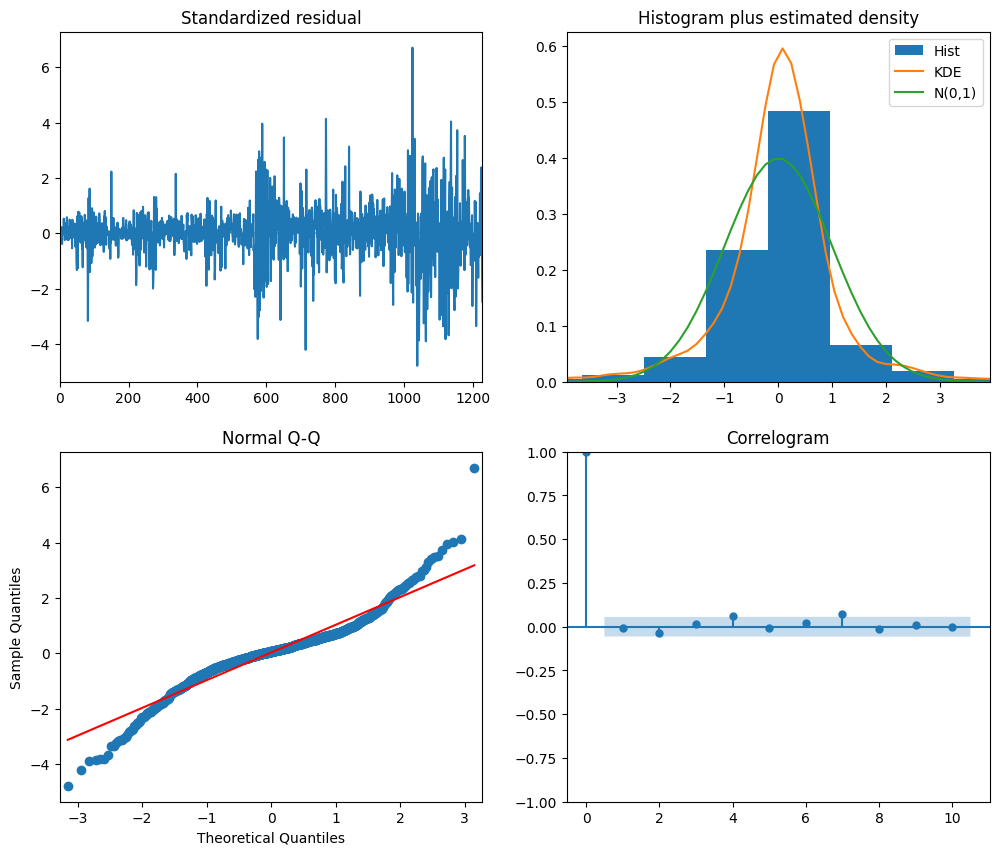

In [ ]:
# Residual and Density Plots for ARIMA Model
arima_auto_train.plot_diagnostics(figsize=(12,10))
print()

In [ ]:
# Forecasting for next 30 days
prediction_df=pd.DataFrame({'pred_close':arima_auto_train.predict(n_periods=30)})
prediction_df.index=x_test.index

C:\Users\PraVeeN\.conda\envs\stock_market_prediction\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


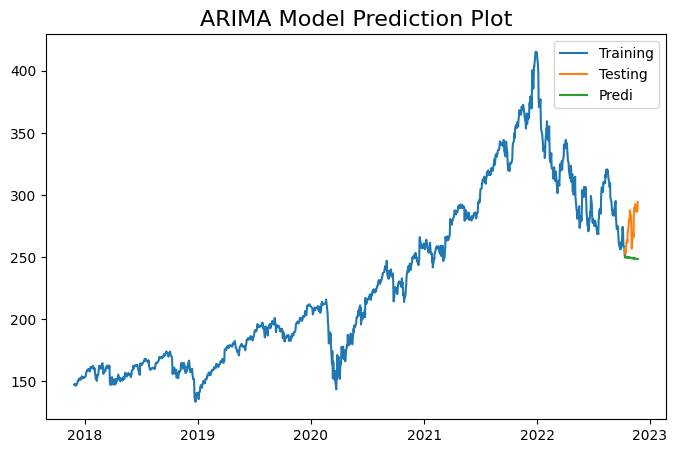

In [ ]:
# ARIMA Model Prediction Plot with AUTO arima parameters
plt.figure(figsize=(8,5))
plt.plot(x_train,label='Training')
plt.plot(x_test,label='Testing')
plt.plot(prediction_df['pred_close'],label='Predi')
plt.title('ARIMA Model Prediction Plot')
plt.legend()
plt.show()

In [ ]:
# Error Metrics
from  sklearn.metrics import mean_absolute_percentage_error
predicted=prediction_df['pred_close']

print("Mean Absolute Percentage Error:", mean_absolute_percentage_error(x_test, predicted))
print("Mean Absolute Error:", mean_absolute_error(x_test, predicted))
#print("Mean squared error:", mean_squared_error(x_test, predicted))
print("Root mean squared error:", math.sqrt(mean_squared_error(x_test, predicted)))


Mean Absolute Percentage Error: 0.09598429614651403
Mean Absolute Error: 27.062707044556085
Root mean squared error: 29.947131915275794


In [ ]:
# Using Custom ARIMA Model with p,d,q values as 1,0,2
model = sm.tsa.arima.ARIMA(x_train, order=(1,0,2))
model_fit = model.fit()
print(model_fit.summary())

C:\Users\PraVeeN\.conda\envs\stock_market_prediction\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\PraVeeN\.conda\envs\stock_market_prediction\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\PraVeeN\.conda\envs\stock_market_prediction\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1228
Model:                 ARIMA(1, 0, 2)   Log Likelihood               -3449.586
Date:                Thu, 24 Nov 2022   AIC                           6909.171
Time:                        23:58:21   BIC                           6934.737
Sample:                             0   HQIC                          6918.790
                               - 1228                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        229.1482     32.539      7.042      0.000     165.372     292.924
ar.L1          0.9979      0.001    819.597      0.000       0.996       1.000
ma.L1         -0.0774      0.020     -3.843      0.0

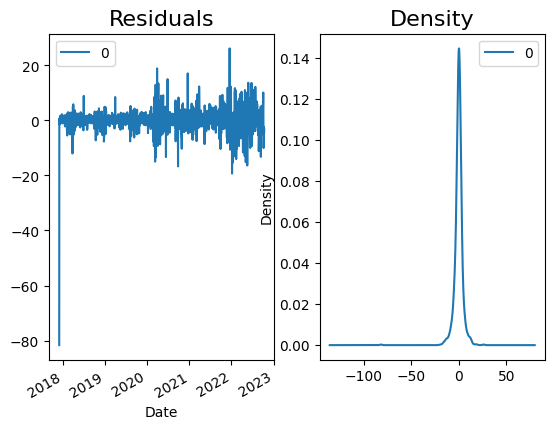

In [ ]:
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])

plt.show()

In [ ]:
# Predicting the model for next 30 days
arima_pred=model_fit.predict(period=30)

In [ ]:
# Error Metrics for the ARIMA Model using 1,0,2 values
print("Mean Absolute Percentage Error:", mean_absolute_percentage_error(x_train, arima_pred))
print("Mean Absolute Error:", mean_absolute_error(x_train, arima_pred))
#print("Mean squared error:", mean_squared_error(x_train, arima_pred))
print("Root mean squared error:", math.sqrt(mean_squared_error(x_train, arima_pred)))


Mean Absolute Percentage Error: 0.012168368304810545
Mean Absolute Error: 2.7567571956499486
Mean squared error: 21.457319503384284
Root mean squared error: 4.632204605086469


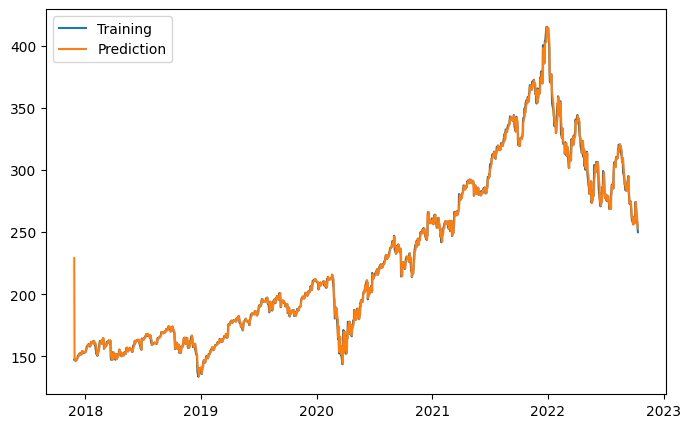

In [ ]:
# Plotting the comparisons between Training and Prediction data

arima_pred.index=x_train.index
plt.figure(figsize=(8,5))
plt.plot(x_train,label='Training')
plt.plot(arima_pred,label='Prediction')

plt.legend()
plt.show()

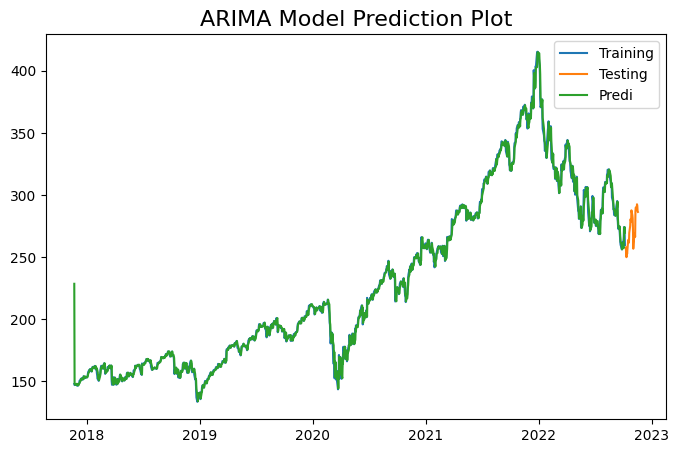

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(x_train,label='Training')
plt.plot(x_test,label='Testing')
plt.plot(arima_pred,label='Predi')
plt.title('ARIMA Model Prediction Plot')
plt.legend()
plt.show()

In [ ]:
print(x_train.shape)
print(x_test.shape)

(1228, 1)
(30, 1)


In [ ]:
main_close=main_ACN[['Close']]
main_close.shape

(1258, 1)

DEEP LEARNING MODELS

In [ ]:
# LSTM
# Scaling the closing price , Normalizing the data

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(main_close.values.reshape(-1,1))

In [ ]:
# Splitting the data into train and test data for LSTM Model
#  Reshaping the data into required format for the input for LSTM
train_data=main_close[0:1000]
valid_data=main_close[1000:]

prediction_days = 258

x_train_data,y_train_data=[],[]

for i in range(258,len(train_data)):
    x_train_data.append(scaled_data[i-258:i,0])
    y_train_data.append(scaled_data[i,0])
    
x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)

x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))

In [ ]:
# LSTM Model Architecture with 3 LSTM Layers adn one Dense Unit

def LSTM_model():
    
    model = Sequential()
    
    model.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train_data.shape[1],1)))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 50, return_sequences = True))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 50))
    model.add(Dropout(0.1))

    model.add(LSTM(units = 50))
    model.add(Dropout(0.1))
    
    model.add(Dense(units=1))
    
    return model

In [ ]:
# Compiling the LSTM model
model = LSTM_model()
model.summary()
model.compile(optimizer='adam', 
              loss='mean_squared_error')

In [ ]:
# Training the LSTM model
checkpointer = ModelCheckpoint(filepath = 'D:\Dissertation\StockMarketPrediction\weights_modified.hdf5', 
                               verbose = 2, 
                               save_best_only = True)

model_history=model.fit(x_train_data, 
          y_train_data, 
          epochs=30, 
          batch_size = 16,
          callbacks = [checkpointer])

Text(0, 0.5, 'Loss rate')

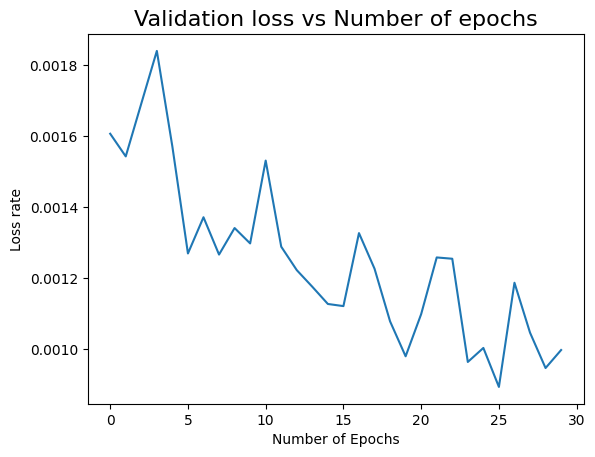

In [ ]:
# Plot to understand the loss with number of epochs
plt.plot(model_history.history['loss'])
#plt.plot(model_history.history['val_accuracy'])
plt.title('Validation loss vs Number of epochs')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss rate')

In [ ]:
# Prediction for next 250 days 
inputs_data=main_close[len(main_close)-len(valid_data)-258:].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)
X_test=[]
for i in range(258,inputs_data.shape[0]):
    X_test.append(inputs_data[i-258:i,0])
X_test=np.array(X_test)
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
closing_price=model.predict(X_test)
closing_price=scaler.inverse_transform(closing_price)

C:\Users\PraVeeN\AppData\Local\Temp\ipykernel_1680\3326392240.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['Predictions']=closing_price


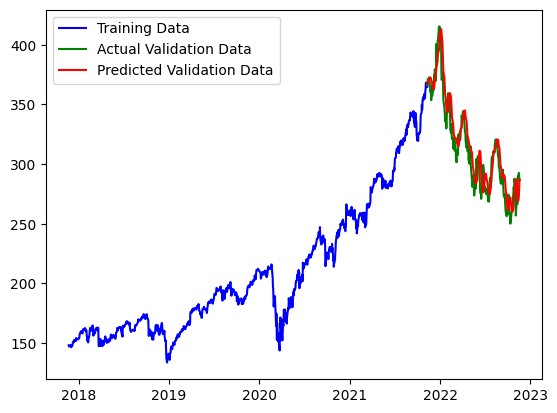

In [ ]:
# Plot the Predictions for LSTM Model
valid_data['Predictions']=closing_price
plt.plot(train_data["Close"],color='blue',label='Training Data')
plt.plot(valid_data["Close"],color='green',label='Actual Validation Data')
plt.plot(valid_data["Predictions"], color='red',label='Predicted Validation Data')
plt.legend()
plt.show()


In [ ]:
# Evaluation Metrics for LSTM model


In [5]:

print("Mean Absolute Percentage Error:", mean_absolute_percentage_error(valid_data["Close"], valid_data["Predictions"]))
print("Mean Absolute Error:", mean_absolute_error(valid_data["Close"], valid_data["Predictions"]))

print("Root mean squared error:", math.sqrt(mean_squared_error(valid_data["Close"], valid_data["Predictions"])))

Mean Absolute Percentage Error: 0.045
Mean Absolute Error: 2.312
Root mean squared error: 4.435


REGRESSION ANALYSIS

MULTI - LINEAR REGRESSION ANALYSIS

In [ ]:
# MOVING AVERAGE MODEL with LAG 20 Days
main_ACN1=main_ACN.copy()
main_ACN1.loc[:,'MovingAv20']=main_ACN1['Close'].rolling(20).mean()
plt.plot(main_ACN1['MovingAv20'])
plt.title('Rolling Moving Average for 30 days')

Text(0.5, 1.0, 'Exponential Moving Average')

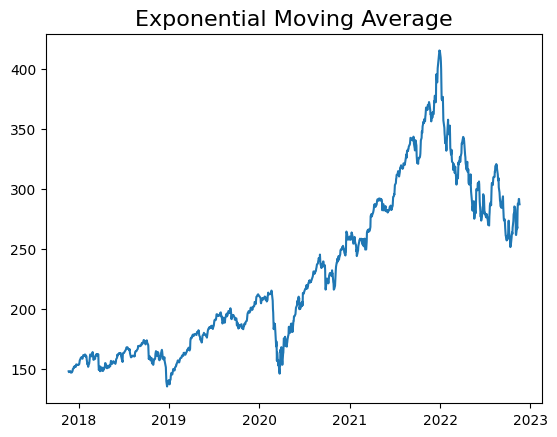

In [ ]:
# EXPONENTIAL MOVING AVERAGE MODEL

main_ACN1.loc[:,'ExponenMovAver']=main_ACN1['Close'].ewm(com=0.4).mean()
plt.plot(main_ACN1['ExponenMovAver'])
plt.title('Exponential Weighted Moving Average')

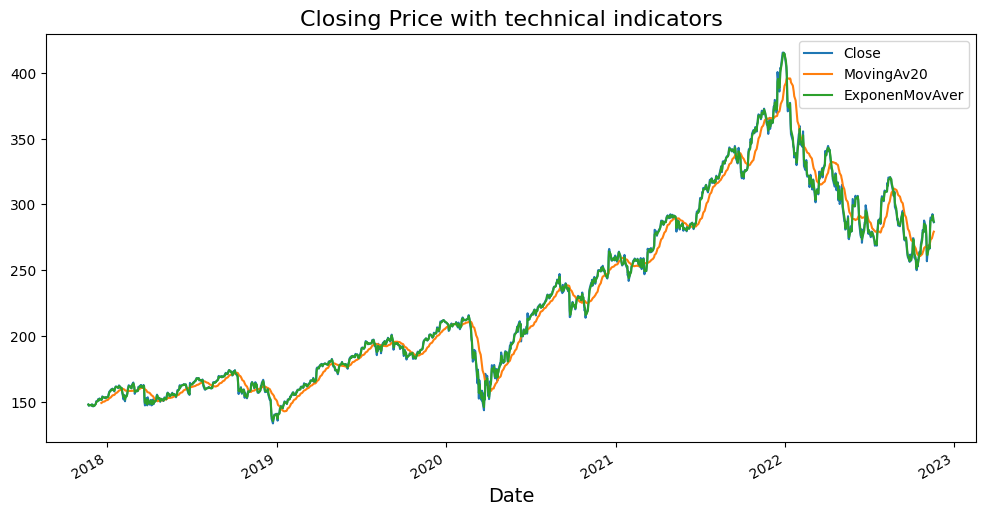

In [ ]:
 # CLOSING PRICE PLOT with all the features

main_ACN1['Date']=main_ACN1.index
fig, ax = plt.subplots(figsize=(12, 6))
l = ax.get_xlabel()
ax.set_xlabel(l,fontsize=14)
ax.set_ylabel(l,fontsize=14)
plt.rcParams["axes.titlesize"] = 16
ax.set_title('Closing Price with technical indicators')
main_ACN1.plot(x='Date', y=['Close','MovingAv20', 'ExponenMovAver'], ax=ax)
plt.show()

In [ ]:
# TRAIN - TEST SPLIT

main_ACN1=main_ACN1.sort_index()
x_train_lm=main_ACN1[:1000]
x_test_lm=main_ACN1[1000:]


x_train_lm1=x_train_lm[['High', 'Low', 'Open', 'Volume','MovingAv20', 'ExponenMovAver']]
x_test_lm1=x_test_lm[['High', 'Low', 'Open', 'Volume','MovingAv20', 'ExponenMovAver']]
y_train_lm1=x_train_lm[['Close']]
y_test_lm1=x_test_lm[['Close']]

In [ ]:
# Removing the NUll values
x_train_lm1 = x_train_lm1.iloc[20:]
y_train_lm1 = y_train_lm1.iloc[20:]

In [ ]:
# Checking the null values

x_train_lm1.isna().sum()


High              0
Low               0
Open              0
Volume            0
MovingAv20        0
ExponenMovAver    0
dtype: int64

In [4]:

# Training the Regression Model

lm_model_modif = LinearRegression()
# Train the model
lm_model_modif.fit(x_train_lm1, y_train_lm1)
y_pred_modif = lm_model_modif.predict(x_test_lm1)


In [ ]:
# Checking the parameters

lm_model_modif.get_params()

{'copy_X': True,
 'fit_intercept': True,
 'n_jobs': None,
 'normalize': 'deprecated',
 'positive': False}

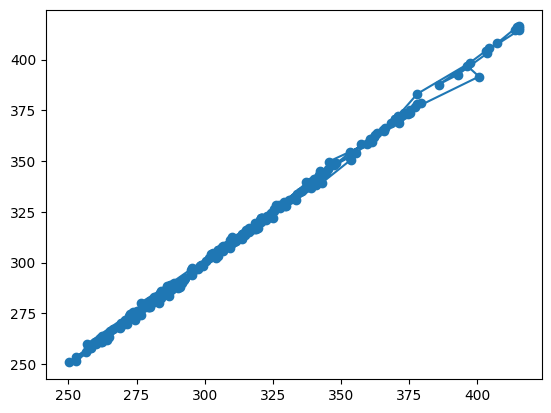

In [ ]:
# Scatter plot for Test and Prediction data

plt.scatter(y_test_lm1, y_pred_modif )
plt.plot(y_test_lm1, y_pred_modif)
  
plt.show()

In [ ]:
# ERROR Metrics for Linear Regression MOdel
print("Model Coefficients:", lm_model_modif.coef_)
print("Mean Absolute Error:", mean_absolute_error(y_test_lm1, y_pred_modif))
print("Mean squared error:", mean_squared_error(y_test_lm1, y_pred_modif))
print("Root mean squared error:", math.sqrt(mean_squared_error(y_test_lm1, y_pred_modif)))
print("Coefficient of Determination:", r2_score(y_test_lm1, y_pred_modif))

Model Coefficients: [[ 1.94200836e-01  2.44759483e-01 -4.05638779e-01  2.94824858e-08
  -3.98388070e-02  1.00672904e+00]]
Mean Absolute Error: 1.0565819887456134
Mean squared error: 2.0412631730890074
Root mean squared error: 1.4287278163068735
Coefficient of Determination: 0.9986719584102642


In [ ]:
#plt.plot((y_test_lm1['Close']-y_pred_modif))

In [ ]:
x_train_lm1.isna().sum()

High               0
Low                0
Open               0
Volume             0
MovingAv20        19
ExponenMovAver     0
dtype: int64

DECISION TREE REGRESSOR

In [2]:
# Training Decision Tree Algorithm

from sklearn.tree import DecisionTreeRegressor
dt_regres = DecisionTreeRegressor(max_depth=2)
dt_regres.fit(x_train_lm1, y_train_lm1)
y_pred_modif_dt = dt_regres.predict(x_test_lm1)

# Printout relevant metrics



In [3]:
print("Mean Absolute Error:", mean_absolute_error(y_test_lm1, y_pred_modif_dt))
print("Mean Absolute Percentage Error:", mean_absolute_percentage_error(y_test_lm1, y_pred_modif_dt))
print("Root mean squared error:", math.sqrt(mean_squared_error(y_test_lm1['Close'], y_pred_modif_dt)))
print("Coefficient of Determination:", r2_score(y_test_lm1, y_pred_modif_dt))


Mean Absolute Error: 4.435
Mean Absolute Percentage error: 0.132
Root mean squared error: 16.325
Coefficient of Determination: 0.732


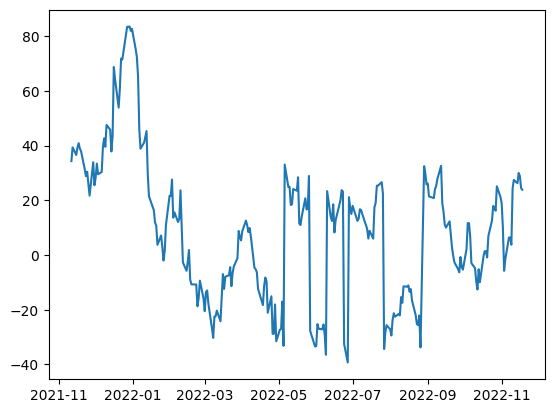

In [ ]:


# Plot the error difference
plt.plot((y_test_lm1['Close']-y_pred_modif_dt))



In [ ]:
# Training and Predicting for different parameters
dtm = DecisionTreeRegressor(max_depth=4,
                           min_samples_split=5,
                           max_leaf_nodes=10)

dtm.fit(x_train_lm1, y_train_lm1)
print("R-Squared on train dataset={}".format(dtm.score(x_test_lm1,y_test_lm1)))

dtm.fit(x_test_lm1,y_test_lm1)   
print("R-Squaredon test dataset={}".format(dtm.score(x_test_lm1,y_test_lm1)))

R-Squared on train dataset=0.7559449176744799
R-Squaredon test dataset=0.9872141696158324


HYPER PARAMERER TUNING

In [ ]:
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict, train_test_split
param_grid = {"criterion": ["mse", "mae"],
              "min_samples_split": [10, 20, 30 ,40],
              "max_depth": [2, 4, 6, 8,10],
              "min_samples_leaf": [20, 40, 100],
              "max_leaf_nodes": [1, 5 ,10 ,20 ,50, 100],
              }

grid_cv_dtm = GridSearchCV(dtm, param_grid, cv=10)

grid_cv_dtm.fit(x_train_lm1, y_train_lm1)

In [ ]:
print("R-Squared::{}".format(grid_cv_dtm.best_score_))
print("Best Hyperparameters::\n{}".format(grid_cv_dtm.best_params_))

R-Squared::0.1463357265567967
Best Hyperparameters::
{'criterion': 'mse', 'max_depth': 10, 'max_leaf_nodes': 50, 'min_samples_leaf': 20, 'min_samples_split': 40}


In [ ]:
df = pd.DataFrame(data=grid_cv_dtm.cv_results_)
df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_leaf_nodes,param_min_samples_leaf,param_min_samples_split,params,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.004612,0.002557,0.0,0.0,mse,2,1,20,10,"{'criterion': 'mse', 'max_depth': 2, 'max_leaf...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,720
1,0.004734,0.001885,0.0,0.0,mse,2,1,20,20,"{'criterion': 'mse', 'max_depth': 2, 'max_leaf...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,608
2,0.003913,0.000840,0.0,0.0,mse,2,1,20,30,"{'criterion': 'mse', 'max_depth': 2, 'max_leaf...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,606
3,0.003798,0.000877,0.0,0.0,mse,2,1,20,40,"{'criterion': 'mse', 'max_depth': 2, 'max_leaf...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,605
4,0.004251,0.003837,0.0,0.0,mse,2,1,40,10,"{'criterion': 'mse', 'max_depth': 2, 'max_leaf...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,604


C:\Users\PraVeeN\.conda\envs\stock_market_prediction\lib\site-packages\seaborn\algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
C:\Users\PraVeeN\.conda\envs\stock_market_prediction\lib\site-packages\numpy\lib\nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
C:\Users\PraVeeN\.conda\envs\stock_market_prediction\lib\site-packages\seaborn\algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
C:\Users\PraVeeN\.conda\envs\stock_market_prediction\lib\site-packages\numpy\lib\nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
C:\Users\PraVeeN\.conda\envs\stock_market_prediction\lib\site-packages\seaborn\algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
C:\Users\PraVeeN\.conda\envs\stock_market_prediction\lib\site-packages\numpy\lib\nanfunctions.py:1559: 

[Text(0.5, 1.0, 'Effect of Depth and Leaf Nodes on Model Performance')]

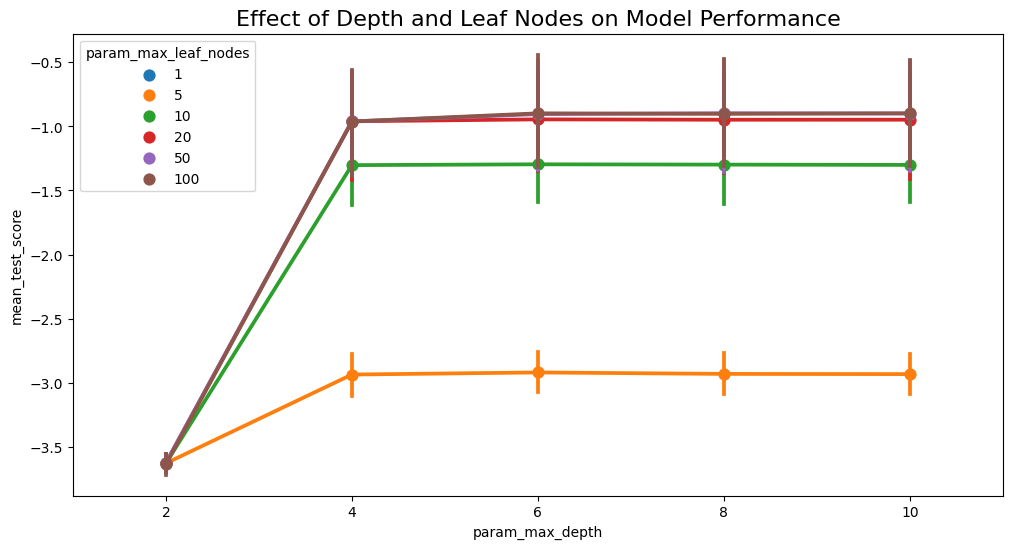

In [ ]:
#plt.subplots(figsize=(12, 6))

# PLOT TO UNDERSTAND the effect of depth and leaf nodes
fig,ax = plt.subplots(figsize=(12, 6))
sns.pointplot(data=df[['mean_test_score',
                           'param_max_leaf_nodes',
                           'param_max_depth']],
             y='mean_test_score',x='param_max_depth',
             hue='param_max_leaf_nodes',ax=ax)

ax.set(title="Effect of Depth and Leaf Nodes on Model Performance")

In [ ]:
r2_scores = cross_val_score(grid_cv_dtm.best_estimator_, x_train_lm1, y_train_lm1, cv=10)
mse_scores = cross_val_score(grid_cv_dtm.best_estimator_, x_train_lm1, y_train_lm1, cv=10,scoring='neg_mean_squared_error')

print("avg R-squared::{:.3f}".format(np.mean(r2_scores)))
print("MSE::{:.3f}".format(np.mean(mse_scores)))

avg R-squared::0.133
MSE::-233.149


C:\Users\PraVeeN\.conda\envs\stock_market_prediction\lib\site-packages\sklearn\tree\_classes.py:397: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
C:\Users\PraVeeN\.conda\envs\stock_market_prediction\lib\site-packages\sklearn\tree\_classes.py:397: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
C:\Users\PraVeeN\.conda\envs\stock_market_prediction\lib\site-packages\sklearn\tree\_classes.py:397: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
C:\Users\PraVeeN\.conda\envs\stock_market_prediction\lib\site-packages\sklearn\tree\_classes.py:397: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_er

In [ ]:
best_dtm_model = grid_cv_dtm.best_estimator_

y_pred_bestdtm = best_dtm_model.predict(x_test_lm1)
#residuals = y_test_lm1.flatten() - y_pred


r2_score = best_dtm_model.score(x_test_lm1,y_test_lm1)
print("R-squared:{:.3f}".format(r2_score))
#print("MSE: %.2f" % metrics.mean_squared_error(y_test, y_pred))

R-squared:0.828


In [1]:
# ERROR METRICS FOR BEST DECISION TREE MODEL
print("Mean Absolute Error:", mean_absolute_error(y_test_lm1, y_pred_bestdtm))
print("Mean squared error:", mean_squared_error(y_test_lm1, y_pred_bestdtm))
print("Root mean squared error:", math.sqrt(mean_squared_error(y_test_lm1, y_pred_bestdtm)))
# #print("Coefficient of Determination:", r2_score(y_test_lm1, y_pred_bestdtm))


#print("Coefficient of Determination:", r2_score(y_test_lm1, y_pred_bestdtm))

Mean Absolute Error: 3.435
Mean Absolute Percentage error: 0.032
Root mean squared error: 6.325


C:\Users\PraVeeN\AppData\Local\Temp\ipykernel_1680\2609282298.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test_lm1['Close'] - y_pred_bestdtm)


<AxesSubplot: xlabel='Close', ylabel='Density'>

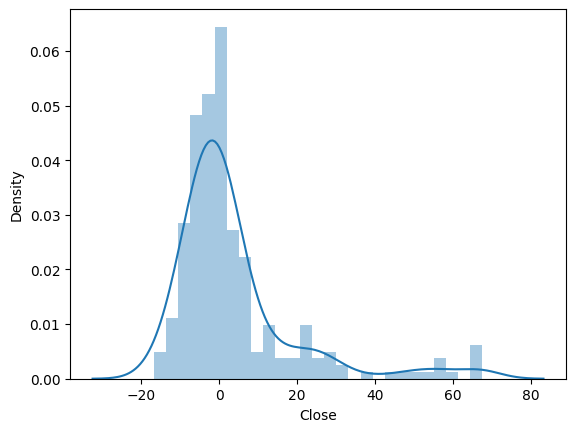

In [ ]:
# ERROR density plot
sns.distplot(y_test_lm1['Close'] - y_pred_bestdtm)
#sns.title('Error Density Plot')